## Inserting necessary libraries

In [3]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

cpu


In [4]:
torch.__version__

'2.2.2'

In [5]:
torchtext.__version__

'0.17.2'

## Task 1: Language Pair Selection and Dataset Description

For this machine translation task, I selected a **Nepali–English parallel corpus**, as Nepali is my native language.

### Dataset Used
- Name:ne-en-parallel-208k  
- Source: Hugging Face Datasets  
- Repository: sharad461/ne-en-parallel-208k  
- Link: https://huggingface.co/datasets/sharad461/ne-en-parallel-208k  

### Dataset Description
This dataset consists of approximately 208,000 parallel sentence pairs between Nepali (ne) and English (en). Each data instance contains an English sentence (en) and its corresponding Nepali translation (ne). The dataset is well-suited for supervised neural machine translation as it provides aligned bilingual text pairs in a clean and structured format.


All credit for the dataset goes to the original author, who curated and published the dataset on Hugging Face. The dataset is used strictly for academic and educational purposes.
https://huggingface.co/datasets/sharad461/ne-en-parallel-208k

In [6]:
from datasets import load_dataset
dataset = load_dataset("sharad461/ne-en-parallel-208k")
print(dataset)

# Check columns
print("columns:", dataset["train"].column_names)
print("example:", dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['ne', 'en'],
        num_rows: 208831
    })
})
columns: ['ne', 'en']
example: {'ne': 'दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शाऊलको मृत्यु भएको केही दिन पछिको कुरा हो। दाऊद त्यहाँ दुइ दिन बसे।', 'en': 'It happened after the death of Saul, when David was returned from the slaughter of the Amalekites, and David had stayed two days in Ziklag;'}


In [7]:
#Split train/val/test (70/20/10)
split_1 = dataset["train"].train_test_split(test_size=0.3, seed=999)     # 70% train, 30% temp
split_2 = split_1["test"].train_test_split(test_size=1/3, seed=999)      # from temp: 20% val, 10% test

# train_ds = split_1["train"]
# val_ds   = split_2["train"]
# test_ds  = split_2["test"]

train_ds = split_1["train"]
val_ds   = split_2["train"]
test_ds  = split_2["test"]

print("sizes:", len(train_ds), len(val_ds), len(test_ds))

# after you create train_ds / val_ds / test_ds
train_ds = train_ds.shuffle(seed=999).select(range(5000))
val_ds   = val_ds.shuffle(seed=999).select(range(500))
test_ds = test_ds.shuffle(seed=999).select(range(1000))


sizes: 146181 41766 20884


## Task 2: Dataset Preparation and Preprocessing

The dataset preparation process involved several structured steps to ensure the data was suitable for training a machine translation model. To begin with, a Nepali–English parallel corpus was sourced from Hugging Face, which provides aligned English sentences along with their Nepali translations. This dataset already included predefined splits for training, validation, and testing, making it convenient to integrate directly into the workflow. The dataset source and details were documented earlier as part of the ETL process.

During the initial exploration phase (EDA), the dataset structure was inspected and lightly adjusted to simplify downstream processing. To make experimentation more manageable and computationally efficient, a random subset of the original training data was selected, reducing the effective training size while preserving diversity.


# Tokenization

Since the dataset contains two languages with different linguistic properties, language-specific tokenizers were used. Given the bilingual nature of the task, different tokenization strategies were applied for each language. English sentences were tokenized using spaCy through TorchText’s `get_tokenizer`, which handles punctuation and common linguistic patterns effectively. For Nepali, a WordPiece-based tokenizer from the `nepalitokenizers` library was used. This choice was motivated by Nepali’s rich morphology, where subword tokenization helps reduce vocabulary sparsity and handle rare word forms more robustly.

- English Tokenization
English text was tokenized using spaCy’s pretrained tokenizer via TorchText.

- Nepali Tokenization
A WordPiece subword tokenizer from the nepalitokenizers library was used. 
    - Credit:
The nepalitokenizers library was developed by Soyuj Basnet using Hugging Face’s tokenizers framework.
Source: https://github.com/basnetsoyuj/nepali-tokenizers


After tokenization, a set of special symbols was introduced to support sequence modeling:
- `<unk>` (index 0): represents unknown or out-of-vocabulary tokens  
- `<pad>` (index 1): used for padding sequences to a uniform length  
- `<sos>` (index 2): marks the beginning of a sentence  
- `<eos>` (index 3): marks the end of a sentence  

These tokens are essential for both training and inference in sequence-to-sequence models.

# Numericalization 
Finally, numericalization was performed using TorchText’s `build_vocab_from_iterator`. This step converted token sequences into integer indices based on the constructed vocabularies for English and Nepali. Once numericalized, the data was ready for further processing steps such as batching, padding, and feeding into the Transformer-based translation model.

# Tokenizing

In [8]:
from torchtext.data.utils import get_tokenizer
from nepalitokenizers import WordPiece
SRC_LANG  = "en"
TARG_LANG = "ne"

token_transform = {}
vocab_transform = {}

# English: spaCy (requires: python -m spacy download en_core_web_sm)
token_transform[SRC_LANG] = get_tokenizer("spacy", language="en_core_web_sm")

# Nepali: WordPiece tokenizer (nepalitokenizers)
wp = WordPiece()
token_transform[TARG_LANG] = wp

In [9]:
ex = train_ds[0]
print("EN:", ex[SRC_LANG])
print("NE:", ex[TARG_LANG])
print("EN tokens:", token_transform[SRC_LANG](ex[SRC_LANG].lower()))
print("NE tokens:", token_transform[TARG_LANG].encode(ex[TARG_LANG].lower()).tokens)

EN: Configure xsldbg's Walk Speed
NE: xsldbg' s हिँडाई गति कन्फिगर गर्नुहोस्
EN tokens: ['configure', 'xsldbg', "'s", 'walk', 'speed']
NE tokens: ['[CLS]', 'x', '##s', '##ld', '##b', '##g', "'", 's', 'हिँड', '##ाई', 'गति', 'कन्फ', '##िग', '##र', 'गर्नुहोस्', '[SEP]']


In [10]:
# Add token columns to datasets
# This function tokenizes a single example based on the specified language
def add_tokens(example, lang):
    if lang == "en":
        # Tokenize English text using spaCy tokenizer
        return {f"{lang}_tok": token_transform[lang](example[lang].lower())}
    else:  # "ne"
        # Tokenize Nepali text using WordPiece tokenizer
        return {f"{lang}_tok": token_transform[lang].encode(example[lang].lower()).tokens}

# Apply tokenization to the training dataset
train_tok = train_ds.map(add_tokens, fn_kwargs={"lang": SRC_LANG})
train_tok = train_tok.map(add_tokens, fn_kwargs={"lang": TARG_LANG})

# Apply tokenization to the validation dataset
val_tok   = val_ds.map(add_tokens, fn_kwargs={"lang": SRC_LANG})
val_tok   = val_tok.map(add_tokens, fn_kwargs={"lang": TARG_LANG})

# Apply tokenization to the test dataset
test_tok  = test_ds.map(add_tokens, fn_kwargs={"lang": SRC_LANG})
test_tok  = test_tok.map(add_tokens, fn_kwargs={"lang": TARG_LANG})

# Verify that token columns were added correctly
print("token cols:", [c for c in train_tok.column_names if c.endswith("_tok")])

# Display a sample of tokenized English and Nepali tokens
print("tok example:", train_tok[0][f"{SRC_LANG}_tok"][:10], "|", train_tok[0][f"{TARG_LANG}_tok"][:10])

Map: 100%|██████████| 1000/1000 [00:00<00:00, 13204.63 examples/s]

token cols: ['en_tok', 'ne_tok']
tok example: ['configure', 'xsldbg', "'s", 'walk', 'speed'] | ['[CLS]', 'x', '##s', '##ld', '##b', '##g', "'", 's', 'हिँड', '##ाई']


In [11]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

## Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers. Here we use built in factory function build_vocab_from_iterator which accepts iterator that yield list or iterator of tokens.

In [12]:
from torchtext.vocab import build_vocab_from_iterator

# Generator function to yield token lists from a specific dataset split
# This is used by torchtext to build vocabularies efficiently
def yield_tokens_from_split(ds, tok_col):
    for tokens in ds[tok_col]:
        yield tokens

# Build vocabulary for the source language (English)
# Tokens with frequency < 2 are discarded to reduce noise
# Special symbols (<unk>, <pad>, <sos>, <eos>) are added at fixed indices
vocab_transform[SRC_LANG] = build_vocab_from_iterator(
    yield_tokens_from_split(train_tok, f"{SRC_LANG}_tok"),
    min_freq=2,
    specials=special_symbols,
    special_first=True
)

# Build vocabulary for the target language (Nepali)
vocab_transform[TARG_LANG] = build_vocab_from_iterator(
    yield_tokens_from_split(train_tok, f"{TARG_LANG}_tok"),
    min_freq=2,
    specials=special_symbols,
    special_first=True
)

# Set default index to <unk> so unseen tokens map to unknown token
vocab_transform[SRC_LANG].set_default_index(UNK_IDX)
vocab_transform[TARG_LANG].set_default_index(UNK_IDX)

# Print vocabulary sizes for verification
print("EN vocab size:", len(vocab_transform[SRC_LANG]))
print("NE vocab size:", len(vocab_transform[TARG_LANG]))

EN vocab size: 5251
NE vocab size: 7631


In [13]:
# Save vocab
torch.save(vocab_transform, "model/vocab.pt")


In [14]:
#see some example
vocab_transform[SRC_LANG](['here', 'is', 'a', 'unknownword', 'a'])

[339, 20, 11, 0, 11]

In [15]:
#we can reverse it....
mapping = vocab_transform[SRC_LANG].get_itos()

#print 1816, for example
mapping[1891]

'arise'

In [16]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [17]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [18]:
#check unique vocabularies
len(mapping)

5251

## Preparing the dataloader

In [20]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# Define a helper function to combine sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        # Iterate over the provided transformations
        for transform in transforms:
            try:
                # Apply the transformation to the text input
                txt_input = transform(txt_input)
            except:
                # If an exception occurs (e.g., if the transform is an encoding operation), catch it
                txt_input = transform.encode(txt_input).tokens
        # Return the transformed text input
        return txt_input
    # Return the function that applies sequential transformations
    return func


# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANG, TARG_LANG]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for item in batch:
        processed_text = text_transform[SRC_LANG](item[SRC_LANG])
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TARG_LANG](item[TARG_LANG]))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

# Create train, val, and test dataloaders

In [21]:
# Set the batch size for data loaders
batch_size = 64

# Creating DataLoader for the training, validation, test set
train_loader = DataLoader(train_tok, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val_tok,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_tok,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [22]:
for ne, _, en in train_loader:
    break

In [23]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Nepali shape: ", ne.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 77])
Nepali shape:  torch.Size([64, 64])


## Designing the model

# Encoder Layer

In [24]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, atten_type, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, atten_type, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

# Encoder

In [25]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, atten_type, device, max_length = 5000):
        super().__init__()
        self.device = device
        self.atten_type = atten_type
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, atten_type,device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src

# General additive layer

# Additive Attention

In [26]:
class AdditiveAttention(nn.Module):
    def __init__(self, head_dim):
        super(AdditiveAttention, self).__init__()
        
        # Linear layers for additive attention
        self.Wa = nn.Linear(head_dim, head_dim)
        self.Ua = nn.Linear(head_dim, head_dim)
        self.V = nn.Linear(head_dim, 1)

    def forward(self, query, keys):
        # Add singleton dimensions for broadcasting
        query = query.unsqueeze(3)
        keys = keys.unsqueeze(2)

        # Apply additive attention mechanism
        features = torch.tanh(self.Wa(query) + self.Ua(keys))
        
        # Calculate attention scores
        scores = self.V(features).squeeze(-1)
        
        return scores

In [27]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, atten_type, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.atten_type = atten_type
        
        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        
        self.dropout  = nn.Dropout(dropout)
        
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        self.additive_attention = AdditiveAttention(self.head_dim)
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        # Calculate attention scores based on the selected attention variant
        if self.atten_type == "general":
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2))
        elif self.atten_type == "additive":
            energy = self.additive_attention(Q, K)
        else:
            raise Exception("Incorrect value. Must be either 'multiplicative', 'general', or 'additive'.")
        
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention

# Position-wise Feedforward Layer

In [28]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

# Decoder Layer

In [29]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, atten_type, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, atten_type, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, atten_type, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

# Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, atten_type, device,max_length = 5000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, atten_type, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

In [31]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        self.params = {'encoder': encoder, 'decoder': decoder,
                       'src_pad_idx': src_pad_idx, 'trg_pad_idx': trg_pad_idx}
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training

In [32]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [33]:
# Define input and output vocabulary sizes
# INPUT_DIM corresponds to the English vocabulary size
# OUTPUT_DIM corresponds to the Nepali vocabulary size
INPUT_DIM = len(vocab_transform[SRC_LANG])
OUTPUT_DIM = len(vocab_transform[TARG_LANG])

# Model dimensionality settings
HID_DIM = 128          # Hidden dimension size for embeddings and transformer layers
ENC_LAYERS = 2         # Number of encoder layers
DEC_LAYERS = 3         # Number of decoder layers

# Multi-head attention configuration
ENC_HEADS = 4          # Number of attention heads in the encoder
DEC_HEADS = 8          # Number of attention heads in the decoder

# Position-wise feedforward layer dimensions
ENC_PF_DIM = 256       # Feedforward dimension in encoder
DEC_PF_DIM = 256       # Feedforward dimension in decoder

# Dropout rates to prevent overfitting
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# Attention mechanism type used in the model
ATTEN_TYPE = 'additive'

# Initialize the encoder with the specified hyperparameters
enc = Encoder(
    INPUT_DIM,
    HID_DIM,
    ENC_LAYERS,
    ENC_HEADS,
    ENC_PF_DIM,
    ENC_DROPOUT,
    ATTEN_TYPE,
    device
)

# Initialize the decoder with the specified hyperparameters
dec = Decoder(
    OUTPUT_DIM,
    HID_DIM,
    DEC_LAYERS,
    DEC_HEADS,
    DEC_PF_DIM,
    DEC_DROPOUT,
    ATTEN_TYPE,
    device
)

# Padding indices used for masking in encoder and decoder
SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [34]:
model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(5251, 128)
    (pos_embedding): Embedding(5000, 128)
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (fc_o): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (additive_attention): AdditiveAttention(
            (Wa): Linear(in_features=32, out_features=32, bias=True)
            (Ua): Linear(in_features=32, out_features=32, bias=True)
            (V): Linear(in_features=32, out_features=1, bias=True)
          

In [35]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

672128
640000
   128
   128
   128
   128
 16384
   128
 16384
   128
 16384
   128
 16384
   128
  1024
    32
  1024
    32
    32
     1
 32768
   256
 32768
   128
   128
   128
   128
   128
 16384
   128
 16384
   128
 16384
   128
 16384
   128
  1024
    32
  1024
    32
    32
     1
 32768
   256
 32768
   128
976768
640000
   128
   128
   128
   128
   128
   128
 16384
   128
 16384
   128
 16384
   128
 16384
   128
   256
    16
   256
    16
    16
     1
 16384
   128
 16384
   128
 16384
   128
 16384
   128
   256
    16
   256
    16
    16
     1
 32768
   256
 32768
   128
   128
   128
   128
   128
   128
   128
 16384
   128
 16384
   128
 16384
   128
 16384
   128
   256
    16
   256
    16
    16
     1
 16384
   128
 16384
   128
 16384
   128
 16384
   128
   256
    16
   256
    16
    16
     1
 32768
   256
 32768
   128
   128
   128
   128
   128
   128
   128
 16384
   128
 16384
   128
 16384
   128
 16384
   128
   256
    16
   256
    16
    16

In [36]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [37]:
def train_epoch(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [38]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
import gc
input_dim   = len(vocab_transform[SRC_LANG])
output_dim  = len(vocab_transform[TARG_LANG])

# # lower learning rate to increase coplexity
# eg: lr of 0.0001 reached train/val loss: 0 within 2 epochs
lr = 0.0000001 
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

epochs  = 5
clip    = 1

In [41]:
atten_map = {'general': 'General Attention', 'additive': 'Additive Attention'}

In [40]:
# Attention variants that we defined
for atten_type in ['general', 'additive']:

    train_loader = DataLoader(train_tok, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    valid_loader = DataLoader(val_tok,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
    test_loader  = DataLoader(test_tok,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

    train_loader_length = len(train_loader)
    val_loader_length   = len(valid_loader)
    test_loader_length  = len(test_loader)

    enc = Encoder(input_dim,
                  HID_DIM,
                  ENC_LAYERS,
                  ENC_HEADS,
                  ENC_PF_DIM,
                  ENC_DROPOUT,
                  atten_type,
                  device)

    dec = Decoder(output_dim,
                  HID_DIM,
                  DEC_LAYERS,
                  DEC_HEADS,
                  DEC_PF_DIM,
                  DEC_DROPOUT,
                  atten_type,
                  device)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    #training hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

    save_path = f'model/{atten_type}_{model.__class__.__name__}.pt'

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    print(f'\n**************** {atten_map[atten_type]} ****************')

    for epoch in range(epochs):

        start_time = time.time()

        train_loss = train_epoch(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        #for plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss
            torch.save([model.params, model.state_dict()], save_path)

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        #lower perplexity is better

    # clearing cache
    # made process faster
    del enc
    del dec
    del model
    torch.cuda.empty_cache()
    gc.collect()


**************** General Attention ****************
Epoch: 01 | Time: 1m 2s
	Train Loss: 8.967 | Train PPL: 7843.719
	 Val. Loss: 8.964 |  Val. PPL: 7813.146
Epoch: 02 | Time: 1m 6s
	Train Loss: 8.965 | Train PPL: 7823.022
	 Val. Loss: 8.961 |  Val. PPL: 7789.446
Epoch: 03 | Time: 1m 8s
	Train Loss: 8.963 | Train PPL: 7808.773
	 Val. Loss: 8.957 |  Val. PPL: 7765.680
Epoch: 04 | Time: 1m 17s
	Train Loss: 8.961 | Train PPL: 7790.703
	 Val. Loss: 8.954 |  Val. PPL: 7742.235
Epoch: 05 | Time: 1m 24s
	Train Loss: 8.958 | Train PPL: 7773.531
	 Val. Loss: 8.951 |  Val. PPL: 7719.025

**************** Additive Attention ****************
Epoch: 01 | Time: 7m 18s
	Train Loss: 8.949 | Train PPL: 7702.921
	 Val. Loss: 8.932 |  Val. PPL: 7569.355
Epoch: 02 | Time: 6m 58s
	Train Loss: 8.944 | Train PPL: 7664.784
	 Val. Loss: 8.925 |  Val. PPL: 7518.423
Epoch: 03 | Time: 7m 8s
	Train Loss: 8.937 | Train PPL: 7611.003
	 Val. Loss: 8.918 |  Val. PPL: 7468.454
Epoch: 04 | Time: 8m 39s
	Train Loss: 8.9

## Observations

### Experiment with Attention Mechanism (Final Epoch Results)

| Attention Variant | Training Loss | Training PPL | Validation Loss | Validation PPL |
|-------------------|---------------|--------------|------------------|-----------------|
| General           | 8.958         | 7773.531     | 8.951            | 7719.025        |
| Additive          | 8.927         | 7533.396     | 8.905            | 7372.079        |


From the experimental results, the Additive Attention mechanism consistently outperforms General Attention across all epochs. By the final epoch, the additive model achieves lower training and validation loss, along with reduced perplexity, indicating better sequence modeling and generalization.

This improvement is expected because additive attention computes alignment scores using a learned feed-forward network, allowing it to model more complex relationships between encoder and decoder states. In contrast, general attention relies on a simpler dot-product formulation, which is less expressive.

Although additive attention requires significantly higher computational time per epoch, the performance gains justify this cost, especially in low-resource translation tasks like English–Nepali, where precise word alignment is crucial.

Overall, additive attention provides better translation quality at the expense of training speed, making it the preferred choice when accuracy is prioritized over efficiency.


## Evaluation and Verification

In [46]:
# Create DataLoader for training data
train_loader = DataLoader(train_tok, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)

# Create DataLoader for validation data
valid_loader = DataLoader(val_tok, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Create DataLoader for test data 
test_loader = DataLoader(test_tok, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Calculate the number of batches in each DataLoader
train_loader_length = len(list(iter(train_loader)))
val_loader_length = len(list(iter(valid_loader)))
test_loader_length = len(list(iter(test_loader)))


In [47]:
import gc
import time
import math

# Get vocabulary sizes for source (English) and target (Nepali)
input_dim   = len(vocab_transform[SRC_LANG])
output_dim  = len(vocab_transform[TARG_LANG])

# Set training hyperparameters
batch_size = 32
lr = 0.0000001

# Set model hyperparameters
hid_dim = 256
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512
dec_pf_dim = 512
enc_dropout = 0.1
dec_dropout = 0.1

# Padding index for source sequences (used in masking)
SRC_PAD_IDX = PAD_IDX

# Create DataLoaders for train/validation/test splits
train_loader = DataLoader(train_tok, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val_tok, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test_tok, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Compute number of batches in each loader (used for averaging loss per epoch)
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

# Training settings
num_epochs = 5
clip       = 1

#### General Model Training

In [44]:
attn_variant = "general"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses_general = []
valid_losses_general = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses_general.append(train_loss)
    valid_losses_general.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')

final_train_loss = train_losses_general[-1]
final_valid_loss = valid_losses_general[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)

average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f} | Final Validation Loss: {final_valid_loss:.3f} | Final Train PPL {final_train_ppl:.3f} | Final Valid PPL {final_valid_ppl:.3f} | Average Time per epoch {average_time_per_epoch} | Overall time {overall_average_time}')



##### general #####
Epoch: 01 | Time: 0m 55s
	Train Loss: 8.973 | Train PPL: 7884.057
	Val. Loss: 8.970 | Val. PPL: 7863.988
Epoch: 02 | Time: 1m 38s
	Train Loss: 8.970 | Train PPL: 7860.996
	Val. Loss: 8.965 | Val. PPL: 7827.835
Epoch: 03 | Time: 1m 36s
	Train Loss: 8.966 | Train PPL: 7831.240
	Val. Loss: 8.961 | Val. PPL: 7792.064
Epoch: 04 | Time: 1m 34s
	Train Loss: 8.963 | Train PPL: 7811.050
	Val. Loss: 8.956 | Val. PPL: 7756.646
Epoch: 05 | Time: 1m 40s
	Train Loss: 8.959 | Train PPL: 7776.164
	Val. Loss: 8.952 | Val. PPL: 7721.342
Final Training Loss: 8.959 | Final Validation Loss: 8.952 | Final Train PPL 7776.164 | Final Valid PPL 7721.342 | Average Time per epoch (89.15177989006042,) | Overall time 0.5678457317838244


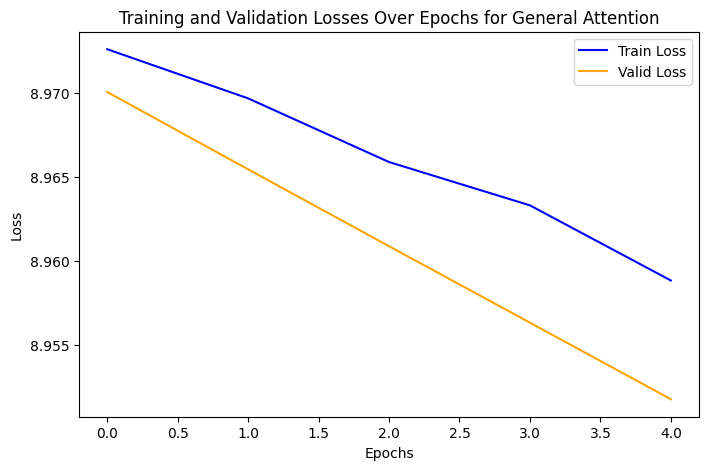

In [45]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses_general, label='Train Loss', color='blue')
ax.plot(valid_losses_general, label='Valid Loss', color='orange')
plt.title('Training and Validation Losses Over Epochs for General Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [46]:
# Path to the saved model file
save_path = 'model/general_Seq2SeqTransformer.pt'

# Load the model parameters and state
params, state = torch.load(save_path)

model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

# Printing the test loss and test perplexity
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


| Test Loss: 8.954 | Test PPL: 7737.279 |


#### Training with Additive Model

In [83]:
attn_variant = "additive"

enc = Encoder(input_dim,
              hid_dim,
              enc_layers,
              enc_heads,
              enc_pf_dim,
              enc_dropout,
              attn_variant,
              device)

dec = Decoder(output_dim,
              hid_dim,
              dec_layers,
              dec_heads,
              dec_pf_dim,
              dec_dropout,
              attn_variant,
              device)

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

best_valid_loss = float('inf')
train_losses = []
valid_losses = []


model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

best_valid_loss = float('inf')
train_losses = []
valid_losses = []
print(f'\n##### {attn_variant} #####')

total_epoch_time = 0 

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    # for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    total_epoch_time += end_time - start_time

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f}')


final_train_loss = train_losses[-1]
final_valid_loss = valid_losses[-1]
final_train_ppl = math.exp(final_train_loss)
final_valid_ppl = math.exp(final_valid_loss)


average_time_per_epoch = total_epoch_time / num_epochs,
overall_average_time = total_epoch_time / (num_epochs * len(train_loader))

print(f'Final Training Loss: {final_train_loss:.3f} | Final Validation Loss: {final_valid_loss:.3f} | Final Train PPL {final_train_ppl:.3f} | Final Valid PPL {final_valid_ppl:.3f} | Average Time per epoch {average_time_per_epoch} | Overall time {overall_average_time}')



##### additive #####
Epoch: 01 | Time: 5m 41s
	Train Loss: 8.994 | Train PPL: 8056.590
	Val. Loss: 8.995 | Val. PPL: 8058.713
Epoch: 02 | Time: 6m 58s
	Train Loss: 8.984 | Train PPL: 7974.060
	Val. Loss: 8.981 | Val. PPL: 7950.510
Epoch: 03 | Time: 7m 11s
	Train Loss: 8.974 | Train PPL: 7894.528
	Val. Loss: 8.967 | Val. PPL: 7842.153
Epoch: 04 | Time: 7m 16s
	Train Loss: 8.964 | Train PPL: 7815.719
	Val. Loss: 8.953 | Val. PPL: 7734.819
Epoch: 05 | Time: 6m 49s
	Train Loss: 8.954 | Train PPL: 7738.371
	Val. Loss: 8.940 | Val. PPL: 7628.424
Final Training Loss: 8.954 | Final Validation Loss: 8.940 | Final Train PPL 7738.371 | Final Valid PPL 7628.424 | Average Time per epoch (407.5284918308258,) | Overall time 2.595722877903349


In [84]:
save_path = 'model/additive_Seq2SeqTransformer.pt'
params, state = torch.load(save_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 8.904 | Test PPL: 7361.088 |


In [85]:
import torch

for name in ["additive", "general"]:
    old_path = f"model/{name}_Seq2SeqTransformer.pt"
    new_path = f"model/{name}_state_dict.pt"
    params, state = torch.load(old_path, map_location="cpu")
    torch.save(state, new_path)
    print("saved", new_path)

saved model/additive_state_dict.pt
saved model/general_state_dict.pt


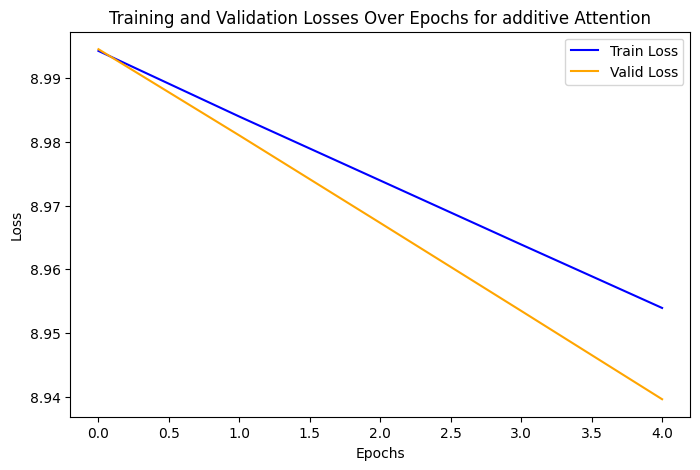

In [86]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

# Plot training and validation losses
ax.plot(train_losses, label='Train Loss', color='blue')
ax.plot(valid_losses, label='Valid Loss', color='orange')
plt.title('Training and Validation Losses Over Epochs for additive Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


## Testing

In [50]:
test_ds[10]['en']

'Judah asked, "What do you want me to give you as proof that I will send you the goat?" Tamar answered, "Give me your seal and its string and your walking stick." Judah gave these things to her. Then Judah and Tamar had sexual relations, and she became pregnant. '

In [51]:
test_ds[10]['ne']

'यहूदाले सोध्यो, "मैले भेडा नपठाउञ्जेलसम्म के बन्धक राख्न चाहन्छौ?" तामारले उत्तर दिई, "तिमीले आफ्नो चिट्ठी पठाउँदा प्रयोग गर्ने मोहर र डोरी देऊ। अनि तिमीले टेक्ने लट्ठी पनी देऊ।" यहूदाले यी सब चीजहरू उसलाई दिएर तामारसित सहवास गरे। तामार गर्भवती भइन्। '

In [52]:
# Get the source text from the test dataset at index 1 in English
src_text = text_transform[SRC_LANG](test_ds[1]['en']).to(device)

# Print or use the source text as needed
print(src_text)


tensor([  2,   0, 185,   7,   4,   0,   0,   0,  16,   0,   0,   0,  27, 932,
         24,   4,   0,   0,   0,   5,   3])


In [53]:
# Get the source text from the test dataset at index 1 in Nepali
trg_text = text_transform[TARG_LANG](train_ds[1]['ne']).to(device)
trg_text

tensor([  2,   4, 628, 339,  93,   5,   3])

In [54]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [55]:
trg_text = trg_text.reshape(1, -1)

In [56]:
src_text.shape, trg_text.shape

(torch.Size([1, 21]), torch.Size([1, 7]))

In [57]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

### 7.1 Test with additive model

In [58]:
import os
load_path = 'model/additive_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)
# Record the start time
start_time = time.time()
model.eval()
with torch.no_grad():
    output, attentions_additive = model(src_text, trg_text) #turn off teacher forcing
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print or use the elapsed time as needed
print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size in megabytes

# Print the model size
print(f"Model size: {model_size:.2f} MB")

Time taken for inference: 0.007822990417480469 seconds
Model size: 45.11 MB


In [59]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 7, 7631])

In [60]:
output = output.squeeze(0)

In [61]:
output.shape

torch.Size([7, 7631])

In [62]:
output = output[1:]
output.shape 

torch.Size([6, 7631])

In [63]:
output_max = output.argmax(1) #returns max indices

Get the mapping of the target language

In [64]:
mapping = vocab_transform[TARG_LANG].get_itos()

In [65]:
output_additive = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_additive.append(token_str)


बी
##r
कार्यान्व
यद्यपि
अध्यापन
##हि


In [66]:
print(output_additive)

['बी', '##r', 'कार्यान्व', 'यद्यपि', 'अध्यापन', '##हि']


## 7.3 Test with General Model

In [67]:
import os
# let's pick one of our model, in this case the additive model
load_path = 'model/general_Seq2SeqTransformer.pt'

params, state = torch.load(load_path)
model = Seq2SeqTransformer(**params, device=device).to(device)
model.load_state_dict(state)

model.eval()
# Record the start time
start_time = time.time()
with torch.no_grad():
    output, attentions_general = model(src_text, trg_text) #turn off teacher forcing
# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print or use the elapsed time as needed
print(f"Time taken for inference: {elapsed_time} seconds")

model_size = os.path.getsize(load_path) / (1024 * 1024)  # Size in megabytes

# Print the model size
print(f"Model size: {model_size:.2f} MB")


Time taken for inference: 0.004784822463989258 seconds
Model size: 45.11 MB


In [68]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 7, 7631])

In [69]:
output = output.squeeze(0)

In [70]:
output.shape

torch.Size([7, 7631])

In [71]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([6, 7631])

In [72]:
output_max = output.argmax(1) #returns max indices

In [73]:
mapping = vocab_transform[TARG_LANG].get_itos()

In [74]:
mapping = vocab_transform[TARG_LANG].get_itos()

In [75]:
output_additive = []
for token in output_max:
    token_str = mapping[token.item()]
    # Check if the token is a language token
    print(token_str)
    if token_str not in ['[CLS]', '[SEP]', '[EOS]','<eos>']:
        output_additive.append(token_str)


देहा
सेन्ट
सेन्ट
सेन्ट
सेन्ट
वनको


### Performance Analysis

| Attention Variant | Average Time per Epoch (s) | Overall Training Time (hrs) | Inference Time | Model Size (MB) | Test Loss | Test Perplexity |
|-------------------|----------------------------|-----------------------------|----------------|------------------|-----------|-----------------|
| General           | 89.15                      | 0.57                        | 0.0078 seconds | 45.11   | 8.954 | 7737.279 |
| Additive          | 407.53                     | 2.60                        | 0.0047 seconds  | 45.11     | 8.904 | 7361.088 |


All models have the same size of 45.11 MB, indicating that the choice of attention mechanism does not affect the number of learnable parameters. In terms of computational efficiency, the general attention variant is the fastest to train, with an average epoch time of 89.15 seconds, whereas additive attention is considerably slower, averaging 407.53 seconds per epoch due to its higher computational complexity.

During inference, both attention mechanisms have low inference time. However, additive attention achieves slightly faster inference time, suggesting that it can produce translations more efficiently once training is complete, despite its slower training phase.

## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [76]:
attentions_additive.shape, attentions_general.shape

(torch.Size([1, 8, 7, 21]), torch.Size([1, 8, 7, 21]))

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [77]:
# Extract attention matrices for the additive, general, and multiplicative attention mechanisms
attention_additive = attentions_additive[0, 0, :, :]
attention_general = attentions_general[0, 0, :, :]
attention_multiplicative = attentions_general[0, 0, :, :]

# Print or use the shapes of the attention matrices as needed
print(attention_additive.shape, attentions_general.shape)


torch.Size([7, 21]) torch.Size([1, 8, 7, 21])


In [78]:
# Construct source tokens by adding start-of-sequence and end-of-sequence tokens
src_tokens = ['<sos>'] + token_transform[SRC_LANG](test_ds[1]['en']) + ['<eos>']

# Print or use the source tokens as needed
print(src_tokens)


['<sos>', 'One', 'member', 'of', 'the', 'District', 'Development', 'Committee', 'or', 'Village', 'Development', 'Committee', 'as', 'designated', 'by', 'the', 'District', 'Development', 'Committee', ',', '<eos>']


In [79]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>', 'देहा', 'सेन्ट', 'सेन्ट', 'सेन्ट', 'सेन्ट', 'वनको']

### Attention Maps

In [80]:
import numpy as np
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, title):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.set_title(title)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


/var/folders/4c/qvr7f7s55bxgydyf0y98d18w0000gn/T/ipykernel_40770/1331759582.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
/var/folders/4c/qvr7f7s55bxgydyf0y98d18w0000gn/T/ipykernel_40770/1331759582.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
/Users/anushkaojha/projects/A3/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2342 (\N{DEVANAGARI LETTER DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anushkaojha/projects/A3/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anushkaojha/projects/A3/.venv/lib/python3.9/site-packages/IPyth

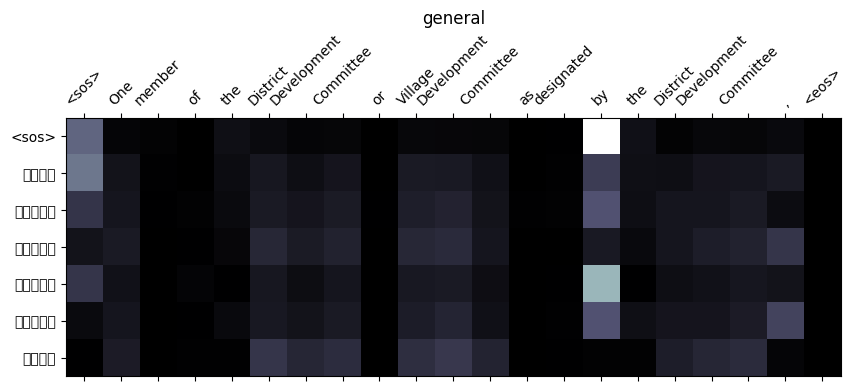

In [81]:
display_attention(src_tokens, trg_tokens, attention_general, "general")

/var/folders/4c/qvr7f7s55bxgydyf0y98d18w0000gn/T/ipykernel_40770/1331759582.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
/var/folders/4c/qvr7f7s55bxgydyf0y98d18w0000gn/T/ipykernel_40770/1331759582.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
/Users/anushkaojha/projects/A3/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 2342 (\N{DEVANAGARI LETTER DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anushkaojha/projects/A3/.venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/anushkaojha/projects/A3/.venv/lib/python3.9/site-packages/IPyth

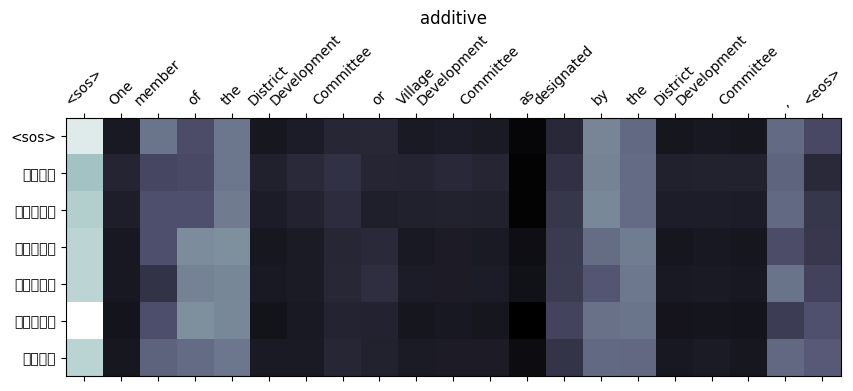

In [82]:
display_attention(src_tokens, trg_tokens, attention_additive, "additive")

### Result Analysis

Based on the discussions in the previous sections, additive attention achieved the lowest testing loss and perplexity among the evaluated attention variants. Therefore, it was selected for implementation in the web application.

However, despite the comparative advantage of additive attention, all models demonstrated poor translation quality. This performance limitation may be attributed to insufficient training epochs, limited model capacity, or overfitting on a reduced dataset.

### Web Application Interface for Machine Translation

To demonstrate the machine translation model in a user-friendly manner, a simple web application was developed using **Dash**, a Python-based web framework built on top of Flask and Plotly. This application serves as an interface between the end user and the trained Transformer-based translation model with attention.

The web application provides a text input area where users can enter an English sentence. Once the **Translate** button is clicked, the input text is passed to the backend inference pipeline. Internally, the application applies the same preprocessing steps used during training, including lowercasing, tokenization, vocabulary lookup, and the addition of special tokens such as `<sos>` and `<eos>`. This ensures consistency between training and inference.

The processed input is then forwarded to the trained sequence-to-sequence Transformer model, which uses the **Additive Attention** mechanism (selected based on experimental results from Task 2). Translation is generated using greedy decoding, where tokens are produced step by step until an end-of-sequence token is reached or a maximum length is exceeded.

The translated Nepali output is decoded back into human-readable text using the target vocabulary and displayed directly on the web page. In addition to the translated sentence, the application also visualizes the attention weights using a heatmap. This attention map illustrates how each generated Nepali token aligns with the input English tokens, helping users better understand the model’s behavior and interpretability.

Overall, the web application acts as a lightweight inference layer that:
- Accepts user input through a browser interface  
- Applies consistent preprocessing and tokenization  
- Loads a pre-trained Transformer model and vocabulary  
- Generates translations in real time  
- Visualizes attention scores for interpretability  

This setup effectively showcases the practical use of the machine translation model while maintaining clarity, usability, and alignment with the underlying NLP pipeline.